C:\Users\User\anaconda3\envs\RL\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.14 and num_layers=1
  warnings.warn(
C:\Users\User\anaconda3\envs\RL\Lib\site-packages\stable_baselines3\common\vec_env\patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 335      |
|    ep_rew_mean        | -0.0407  |
| time/                 |          |
|    fps                | 601      |
|    iterations         | 100      |
|    time_elapsed       | 0        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -1.4     |
|    explained_variance | -1.09    |
|    learning_rate      | 0.0007   |
|    n_updates          | 99       |
|    policy_loss        | -0.0276  |
|    std                | 0.978    |
|    value_loss         | 0.000638 |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 335      |
|    ep_rew_mean        | -0.138   |
| time/                 |          |
|    fps                | 595      |
|    iterations   

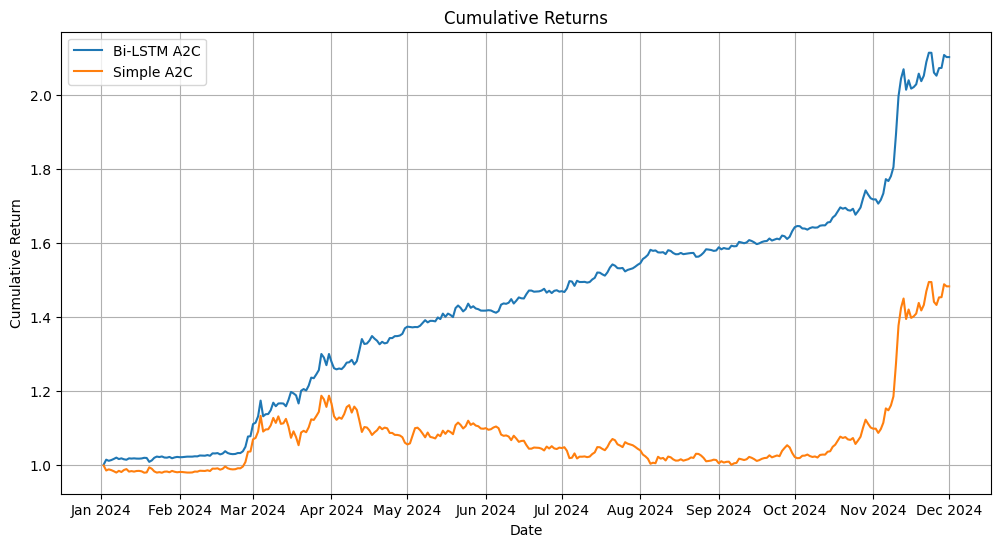

         Method  Cumulative Return  Sharpe Ratio  Sortino Ratio  Max Drawdown
0   Bi-LSTM A2C           2.102321      0.261509       0.433521     -0.036114
1    Simple A2C           1.482915      0.102898       0.176754     -0.157258
2  Buy-and-Hold           2.447755           NaN            NaN           NaN


In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
from stable_baselines3 import A2C
from gym import spaces, Env
import matplotlib.pyplot as plt
import random

# Set seed for reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Load and preprocess data
def load_and_preprocess(file_name):
    data = pd.read_csv(file_name)
    data["Date"] = pd.to_datetime(data["Date"])
    data = data.sort_values(by="Date")

    numeric_data = data.drop(columns=["Date"])
    numeric_data = numeric_data[['Close'] + [col for col in numeric_data.columns if col != 'Close']]

    scaler = MinMaxScaler()
    normalized_data = scaler.fit_transform(numeric_data)
    data[numeric_data.columns] = normalized_data

    return data, scaler

# Create sequences for time series modeling
def create_sequences(data, sequence_length=30):
    sequences = []
    targets = []
    for i in range(len(data) - sequence_length):
        seq = data[i:i+sequence_length]
        target = data[i+sequence_length, 0]  # Assuming the target is the first column (e.g., Close price)
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define Bi-LSTM model
class BiLSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(BiLSTMModel, self).__init__()
        self.bilstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, 1)

    def forward(self, x):
        bilstm_out, _ = self.bilstm(x)
        return self.fc(bilstm_out[:, -1, :])

# Custom trading environment
class TradingEnv(Env):
    def __init__(self, data, sequence_length=30):
        super(TradingEnv, self).__init__()
        self.data = data
        self.sequence_length = sequence_length
        self.current_step = 0
        self.total_steps = len(data) - sequence_length
        self.portfolio_value = 1.0

        # Action and observation space
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)  # Continuous actions
        self.observation_space = spaces.Box(low=0, high=1, shape=(sequence_length, data.shape[1]), dtype=np.float32)

    def reset(self):
        self.current_step = 0
        self.portfolio_value = 1.0
        return self._next_observation()

    def _next_observation(self):
        return self.data[self.current_step:self.current_step + self.sequence_length]

    def step(self, action):
        self.current_step += 1
        reward = 0
        done = self.current_step >= self.total_steps

        if not done:
            current_price = self.data[self.current_step, 0]
            prev_price = self.data[self.current_step - 1, 0]

            reward = action[0] * (current_price - prev_price)  # Continuous action impact

        self.portfolio_value += reward
        obs = self._next_observation() if not done else None
        return obs, reward, done, {"portfolio_value": self.portfolio_value}

# Evaluate trading strategy
def evaluate_trading_strategy(env, model):
    obs = env.reset()
    done = False
    portfolio_values = [1.0]

    while not done:
        action, _ = model.predict(obs, deterministic=True)
        obs, reward, done, info = env.step(action)
        portfolio_values.append(info.get("portfolio_value", 1.0))

    return portfolio_values

# Performance metrics
def calculate_metrics(portfolio_values):
    daily_returns = np.diff(portfolio_values) / portfolio_values[:-1]
    cumulative_return = portfolio_values[-1] / portfolio_values[0] - 1
    sharpe_ratio = np.mean(daily_returns) / np.std(daily_returns) if np.std(daily_returns) > 0 else 0
    sortino_ratio = np.mean(daily_returns) / np.std([r for r in daily_returns if r < 0]) if np.std([r for r in daily_returns if r < 0]) > 0 else 0
    max_drawdown = np.min(portfolio_values / np.maximum.accumulate(portfolio_values) - 1)
    return cumulative_return, sharpe_ratio, sortino_ratio, max_drawdown

# Main execution
if __name__ == "__main__":
    # Load data
    data, scaler = load_and_preprocess("Book3.csv")
    train_data = data[(data["Date"].dt.year >= 2017) & (data["Date"].dt.year <= 2023)].drop(columns=["Date"]).values
    test_data = data[data["Date"].dt.year == 2024].drop(columns=["Date"]).values

    X_train, y_train = create_sequences(train_data)
    X_test, y_test = create_sequences(test_data)

    # Train Bi-LSTM model
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    bilstm_model = BiLSTMModel(input_dim=X_train.shape[2], hidden_dim=224, num_layers=1, dropout=0.14).to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(bilstm_model.parameters(), lr=0.0019)

    train_loader = DataLoader(TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32)), batch_size=32, shuffle=True)

    for epoch in range(50):
        bilstm_model.train()
        train_loss = 0.0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            predictions = bilstm_model(X_batch).squeeze()
            loss = criterion(predictions, y_batch)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

    # Create environments for A2C
    bilstm_env = TradingEnv(test_data)
    simple_env = TradingEnv(test_data)

    # Train A2C models
    a2c_bilstm_model = A2C("MlpPolicy", bilstm_env, learning_rate=0.00021945249490720997, gamma=0.9615609605249118, n_steps=10, ent_coef=3.1595915389526, vf_coef=0.6476589390876872, max_grad_norm=0.8982203958441722)
    a2c_bilstm_model.learn(total_timesteps=50000)

    a2c_simple_model = A2C("MlpPolicy", simple_env, verbose=1)
    a2c_simple_model.learn(total_timesteps=50000)

    # Evaluate strategies
    portfolio_values_bilstm = evaluate_trading_strategy(bilstm_env, a2c_bilstm_model)
    portfolio_values_simple = evaluate_trading_strategy(simple_env, a2c_simple_model)

    cumulative_return_bilstm, sharpe_bilstm, sortino_bilstm, max_drawdown_bilstm = calculate_metrics(portfolio_values_bilstm)
    cumulative_return_simple, sharpe_simple, sortino_simple, max_drawdown_simple = calculate_metrics(portfolio_values_simple)

    # Buy-and-Hold strategy
    buy_hold_return = test_data[-1, 0] / test_data[0, 0] - 1

    # Generate date range for 2024
    test_dates = pd.date_range(start="2024-01-01", periods=len(portfolio_values_bilstm))

    # Calculate cumulative returns
    cumulative_returns_bilstm = np.cumprod([1 + r for r in np.diff(portfolio_values_bilstm) / portfolio_values_bilstm[:-1]])
    cumulative_returns_simple = np.cumprod([1 + r for r in np.diff(portfolio_values_simple) / portfolio_values_simple[:-1]])

    # Plot cumulative returans
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates[1:], cumulative_returns_bilstm, label="Bi-LSTM A2C")
    plt.plot(test_dates[1:], cumulative_returns_simple, label="Simple A2C")
    plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b %Y"))
    plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.MonthLocator())

    plt.legend()
    plt.title("Cumulative Returns")
    plt.xlabel("Date")
    plt.ylabel("Cumulative Return")
    plt.grid()
    plt.show()

    # Print results
    results = pd.DataFrame({
        "Method": ["Bi-LSTM A2C", "Simple A2C", "Buy-and-Hold"],
        "Cumulative Return": [cumulative_returns_bilstm[-1], cumulative_returns_simple[-1], buy_hold_return],
        "Sharpe Ratio": [sharpe_bilstm, sharpe_simple, None],
        "Sortino Ratio": [sortino_bilstm, sortino_simple, None],
        "Max Drawdown": [max_drawdown_bilstm, max_drawdown_simple, None]
    })
    print(results)
